In [1]:
import requests
import json
import pandas as pd
import numpy as np
from time import sleep
from datetime import datetime, timezone
from datetime import time

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator

from utils import get_block_number_from_timestamp

In [2]:
df_timestamp_block_origin = pd.read_csv('./daily_data/timestamp_block.csv')
print("Origin date fetch (UTC):", datetime.utcfromtimestamp(df_timestamp_block_origin['timestamp'].iloc[-1]))
print("---------------------------------------")

origin_timestamp = df_timestamp_block_origin['timestamp'].iloc[-1]
dt = datetime.now()
last_timestamp = int(datetime(
    year=dt.year, month=dt.month, day=dt.day, 
    hour=0, minute=0, second=0, microsecond=0, 
    tzinfo=timezone.utc
).timestamp())

interval = 86400 # 1 day
df_timestamp_block = df_timestamp_block_origin

for timestamp in range(origin_timestamp, last_timestamp+1, interval):
    block = get_block_number_from_timestamp(timestamp)
    values = [{
        "timestamp": timestamp,
        "block": block
    }]
    df_timestamp_block = df_timestamp_block.append(values)
    sleep(0.25)

# not sure why got many duplicated, just use drop
df_timestamp_block.drop_duplicates(keep='first', inplace=True) 

# save
df_timestamp_block.reset_index(inplace = True, drop = True)
df_timestamp_block.to_csv('./daily_data/timestamp_block.csv', index=False)

print("Last date fetch (UTC):", datetime.utcfromtimestamp(df_timestamp_block['timestamp'].iloc[-1]))

Origin date fetch (UTC): 2022-08-16 00:00:00
---------------------------------------
Last date fetch (UTC): 2022-08-17 00:00:00


In [15]:
df_fres =  pd.read_csv('./daily_data/new_subgraph/fres.csv')

base_url = "https://v4.subgraph.polygon.oceanprotocol.com"
route = "/subgraphs/name/oceanprotocol/ocean-subgraph"
url = base_url + route
query = \
f"""
{{fixedRateExchanges(
    first: 1000, 
    # block: {{number: 30077156}}
    ) 
    {{
    active
    datatokenBalance
    price
    totalSwapValue
    datatoken {{
      cap
      holderCount
      orderCount
      symbol
      name
      publishMarketFeeAmount
      nft {{
        name
        transferable
        symbol
        owner
      }}
      address
    }}
    
  }}}}
    """
headers = {"Content-Type": "application/json"}
payload = json.dumps({"query": query})
response = requests.request("POST", url, headers=headers, data=payload)

data = json.loads(response.text)
df_data = pd.json_normalize(data['data']['fixedRateExchanges'])

dt = datetime.now()
now_timestamp = int(datetime(
    year=dt.year, month=dt.month, day=dt.day, 
    hour=dt.hour, minute=dt.minute, second=dt.second, microsecond=0, 
    tzinfo=timezone.utc
).timestamp())
df_data["timestamp"] = now_timestamp

df_fres = pd.concat([df_fres, df_data], ignore_index=True, sort=False)
# df_fres = df_data

df_fres.drop_duplicates(keep='first', inplace=True,subset=['datatoken.symbol', 'datatoken.name','timestamp'])
df_fres.reset_index(inplace = True, drop = True)
# df_fres.to_csv('./daily_data/new_subgraph/fres.csv', index=False)

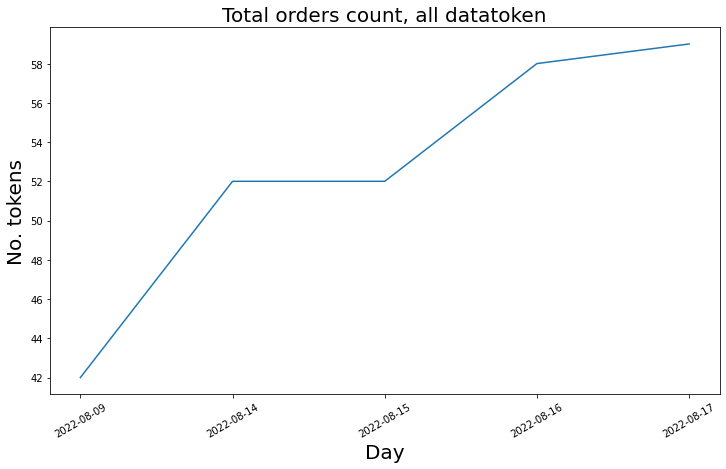

In [7]:
x = []
y = []
for timestamp in df_fres['timestamp'].unique():
    dt = datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d')
    total_orderCount = df_fres.loc[df_fres['timestamp'] == timestamp]['datatoken.orderCount'].astype(int).sum()
    x.append(dt)
    y.append(total_orderCount)
fig, ax = plt.subplots()

plt.plot(x,y)
plt.xlabel("Day", fontsize=20)
plt.ylabel("No. tokens", fontsize=20)
plt.title(f"Total orders count, all datatoken", fontsize=20)
plt.xticks(rotation=30)
# plt.legend(fontsize=10)

ax.tick_params(axis='x',rotation=30)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 6.75)

# show integer only
ax.yaxis.set_major_locator(MaxNLocator(integer=True))


In [31]:
datatokens_with_dcv_symbol = [] # array of datatokens with volume
# TODO: replace with dataframe which has 2 columns: y.iloc[-1] and symbol to sort by latest volume (y.iloc[-1])
for symbol in df_fres['datatoken.symbol'].unique():
    _df = df_fres.loc[df_fres['datatoken.symbol'] == symbol]
    # x = pd.to_datetime(_df["timestamp"], unit='s').dt.strftime('%Y-%m-%d')
    y = _df['datatoken.orderCount'].astype(float)
    if y.iloc[-1]:
        # plt.plot(x,y)
        # datatokens_with_dcv += 1
        datatokens_with_dcv_symbol.append(symbol)
    

# df_fres.head()

In [40]:
print(f'Out of total {len(df_fres["datatoken.symbol"].unique())} datatoken, {(len(datatokens_with_dcv_symbol))} has sale volume out')

Out of total 91 datatoken, 30 has sale volume out
